In [88]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [178]:
#Import data for processing

filename = "./19-08-2020/FLPID_circle3.xlsx"
data = pd.read_excel(filename, 
                    names = ["globaltime","dt",'rb1x','rb1y','rb1z','rb2x','rb2y','rb2z',
                            'rb3x','rb3y','rb3z','rb4x','rb4y','rb4z','rb5x','rb5y','rb5z',
                            'rb6x','rb6y','rb6z','rb7x','rb7y','rb7z','rb8x','rb8y','rb8z',
                            'xd','yd','thetad'])
while data.iloc[0]['rb1z']==0.0:    
    data = data.drop(0)
    data.index-=1
      
data.iloc[0]['rb1z']        


93.2848919933962

In [230]:
#calculate robot position at each point

#calculate the center of the robot
Adet = (data['rb1x']*(data['rb4y']-data['rb6y']) -
       data['rb1y']*(data['rb4x']-data['rb6x']) +
       data['rb4x']*data['rb6y']-data['rb6x']*data['rb4y'])

Bdet = ((data['rb1x']**2+data['rb1y']**2)*(data['rb6y']-data['rb4y'])  +
       (data['rb4x']**2+data['rb4y']**2)*(data['rb1y']-data['rb6y'])  +
       (data['rb6x']**2+data['rb6y']**2)*(data['rb4y']-data['rb1y']) )

Cdet = ((data['rb1x']**2+data['rb1y']**2)*(data['rb4x']-data['rb6x'])  +
       (data['rb4x']**2+data['rb4y']**2)*(data['rb6x']-data['rb1x'])  +
       (data['rb6x']**2+data['rb6y']**2)*(data['rb1x']-data['rb4x']) )

x_r = -Bdet/(2.*Adet)/1000.+Bdet[0]/(2.*Adet[0])/1000. #robot global position x in meters (adjusted to origin)
y_r = -Cdet/(2.*Adet)/1000.+Cdet[0]/(2.*Adet[0])/1000. #robot global position y in meters


x_mid = (data['rb1x']+data['rb8x'])/2.+Bdet[0]/(2.*Adet[0])/1000. #calculate the midpoint of wheel 1 (adjusted to origin)
y_mid = (data['rb1y']+data['rb8y'])/2.+Cdet[0]/(2.*Adet[0])/1000.

#rotate desired position to be in line with robot
#xd_rot =data['xd']*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))-data['yd']*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
#yd_rot =data['yd']*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))+data['xd']*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
xd_rot = data['xd']
yd_rot = data['yd']


xr_rot =x_r*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))-y_r*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
yr_rot =y_r*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))+x_r*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))


#set robot initial position to the origin
#x_r = x_r+Bdet[0]/(2.*Adet[0])/1000. #robot position x in meters starting at origin
#y_r = y_r+Cdet[0]/(2.*Adet[0])/1000. #robot global position y in meters  starting at origin
theta_r = np.arctan2(y_mid-y_r,x_mid-x_r) - np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]) #robot angle starting at 0

In [231]:
#cast robot info into a new dataframe

pdata = pd.DataFrame()
pdata.insert(0,"globaltime", data['globaltime'],True) #get global time
pdata.insert(1, "x_r", xr_rot,True) #get robot positions (adjusted to origin)
pdata.insert(2, "y_r", yr_rot,True)
pdata.insert(3, "theta_r", theta_r,True)

pdata.insert(4, "x_d", xd_rot,True) #get robot desired positions (adjusted for starting orientation)
pdata.insert(5, "y_d", yd_rot,True)
pdata.insert(6, "theta_d", data['thetad'],True)

pdata.insert(7,'e_x', pdata['x_r']-pdata['x_d']) #calculate the errors at each point
pdata.insert(7,'e_y', pdata['y_r']-pdata['y_d'])
pdata.insert(7,'e_theta', pdata['theta_r']-pdata['theta_d'])

for i in range (1000,2048): #use only to drop meaningless data
    pdata = pdata.drop(i)

In [232]:
RMSE_x = np.sqrt(sum(pdata['e_x']**2)/len(pdata['e_x']))
RMSE_y = np.sqrt(sum(pdata['e_y']**2)/len(pdata['e_y']))
RMSE_theta = np.sqrt(sum(pdata['e_theta']**2)/len(pdata['e_theta']))

0.00556409316234626
0.99998452031383
85.5050242276387


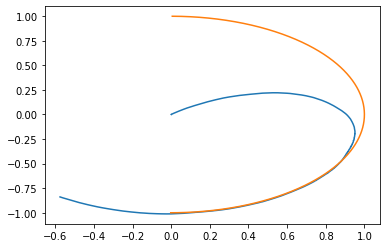

In [233]:
ax = plt.subplot(1,1,1)
ax.plot(pdata['x_r'],pdata['y_r'],pdata['x_d'],pdata['y_d'])
ax.plot(pdata.iloc[0]['x_d'],pdata.iloc[0]['y_d'],linewidth=6)
print(pdata.iloc[0]['x_d'])
print(pdata.iloc[0]['y_d'])
print(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0])*180/np.pi)
#plt.plot(pdata['x_r'],pdata['y_r'],pdata['x_d'],pdata['y_d'])
#plt.plot(pdata[0]['x_d'],pdata[0]['y_d'])
plt.show()

In [152]:
print(RMSE_x)
print(RMSE_y)
print(RMSE_theta)

0.3734848861876565
0.443579305603304
1.4069257310686818


In [85]:
pdata

,globaltime,x_r,y_r,theta_r,x_d,y_d,theta_d,e_theta,e_y,e_x
1,0.026725,-0.000034,-0.000015,0.000038,-0.802269,0.596963,0,0.000038,-0.596979,0.802235
2,0.046813,-0.000034,-0.000038,-0.000007,-0.800381,0.599492,0,-0.000007,-0.599530,0.800347
3,0.066789,-0.000003,-0.000036,-0.000006,-0.798496,0.602000,0,-0.000006,-0.602036,0.798493
4,0.086937,-0.000024,-0.000035,-0.000008,-0.796587,0.604524,0,-0.000008,-0.604559,0.796563
5,0.106870,-0.000032,-0.000017,0.000003,-0.794690,0.607016,0,0.000003,-0.607033,0.794658
...,...,...,...,...,...,...,...,...,...,...
2044,41.967646,1.032693,0.111416,-0.517650,-0.586075,0.810257,0,-0.517650,-0.698840,1.618768
2045,41.987064,1.032921,0.108050,-0.519630,-0.583601,0.812041,0,-0.519630,-0.703991,1.616522
2046,42.007057,1.032909,0.104537,-0.521512,-0.581048,0.813869,0,-0.521512,-0.709332,1.613957
2047,42.027098,1.033420,0.101831,-0.523475,-0.578483,0.815694,0,-0.523475,-0.713863,1.611903


In [225]:
data

,globaltime,dt,rb1x,rb1y,rb1z,rb2x,rb2y,rb2z,rb3x,rb3y,...,rb6z,rb7x,rb7y,rb7z,rb8x,rb8y,rb8z,xd,yd,thetad
0,0.035422,0.02,75.479338,378.699200,93.284892,185.358855,407.484898,92.022150,553.270332,499.225319,...,98.052685,21.910945,575.040157,94.655642,-8.425142,468.836285,93.121239,0.005564,0.999985,0
1,0.055416,0.02,75.527047,378.794328,93.194407,185.346374,407.512388,92.066461,553.238225,499.337832,...,98.112200,21.932593,575.051301,94.716658,-8.425504,468.867556,93.167176,0.008705,0.999962,0
2,0.081529,0.02,75.502993,378.677434,93.349126,185.385107,407.525961,91.984311,553.274579,499.297860,...,97.958758,21.962658,575.096904,94.593429,-8.388206,468.859476,93.102971,0.012806,0.999918,0
3,0.098165,0.02,75.514577,378.701123,93.279219,185.359564,407.483297,92.098117,553.288415,499.246286,...,98.320095,21.939916,575.021750,94.738290,-8.403184,468.845838,93.137089,0.015419,0.999881,0
4,0.115787,0.02,75.503352,378.767155,93.210033,185.349161,407.488971,92.043332,553.255185,499.277282,...,98.258017,21.943473,575.055693,94.665329,-8.423238,468.873075,93.122489,0.018187,0.999835,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,41.955753,0.02,770.627967,-324.387714,94.420282,880.007218,-293.854038,93.401746,1246.029851,-194.868932,...,96.304292,713.371506,-128.702515,94.419719,685.109966,-235.879886,93.601146,0.302399,0.953181,0
2044,41.975863,0.02,768.593216,-326.644844,94.576698,877.871985,-295.947510,93.536097,1243.962450,-197.195263,...,96.776366,711.215444,-130.758603,94.598277,682.986340,-237.947665,93.495661,0.305409,0.952221,0
2045,41.996187,0.02,766.386315,-329.160558,95.005240,875.569393,-298.017562,93.379390,1241.605243,-199.296828,...,96.422575,709.038269,-133.152826,94.625823,680.774415,-240.153226,93.691123,0.308447,0.951241,0
2046,42.016097,0.02,764.086991,-330.965817,94.726174,873.407382,-300.329550,93.645921,1239.558962,-201.446177,...,96.498556,706.819416,-135.198277,94.648186,678.552584,-242.274242,93.706738,0.311421,0.950272,0
